Caio Teles Cunha 2020006434

Ivan Vilaça de Assis 2021421931

## Introdução

Neste trabalho, vamos analisar a solucação do problema do Caixeiro Viajante usando o Simulated Annealing. O qual se baseia em um método da metalurgia e que vamos adaptar para o TSP tomando a distância como a energia.

Neste método determinamos uma temperatura inicial e vamos reduzindo-a de acordo com um protocolo determinado por nós, vamos usar redução exponencial.

O diferencial do Simulated Annealing é seu caráter estocástico ao usar da temperatura para talvez mudar para uma distância maior. Isso ajuda a evitar que o algoritmo fique presos em mínimos locais e aumenta as chances de encontrar o mínimo global. 

In [52]:
from numba import jit
import numpy as np
import matplotlib.pyplot as plt

N=130       # Numero de cidades

rng = np.random.default_rng(seed=42)   # Define as posições aleatórias das cidades
x=rng.random(N)
y=rng.random(N)

# define o caminho que liga as cidades (inicialmente a sequencia como foi criada)
pathini = np.zeros(N,dtype=np.int16)
for i in range(N):
    pathini[i]=i

In [53]:
#define a distancia entre duas cidades quaisquer
@jit(nopython=True)
def distances(N,x,y):
    
    dist = np.zeros((N,N),dtype=np.float32)
    for i in range(N):
        for j in range(N):
            dist[i,j] = np.sqrt((x[i]-x[j])*(x[i]-x[j])+(y[i]-y[j])*(y[i]-y[j]))
            
    return dist

In [54]:
@jit(nopython=True)
def custo(N,path,dist):
    # calcula a distancia total percorrida pela caminhada
    ener = 0
    for i in range(N-1):
        ener += dist[path[i],path[i+1]]
    ener += dist[path[0],path[N-1]]     # conecta a última e a primeira cidades do caminho
    
    return ener

In [55]:
@jit(nopython=True)
def newpath(N,path):
    
    # define uma nova caminhada
    
    newpath = np.zeros(N,dtype=np.int16)

    i=np.random.randint(N)   # escolhe uma posição aleatória da caminhada
    j=i
    while j==i:
        j=np.random.randint(N)  # escolhe outra posição 
    if i>j:                    # ordena os índices
        ini = j
        fin = i
    else:
        ini = i
        fin = j

    for k in range(N):        # inverte o sentido em que percorre o caminho entre os indices escolhidos
        if k >= ini and k <= fin:
            newpath[k] = path[fin-k+ini]
        else:
            newpath[k] = path[k]

    return newpath,ini,fin



In [56]:
@jit(nopython=True)
def mcstep(N,beta,en,path,best_e,best_p,dist):
    # realiza um passo de Monte Carlo
    np1 = np.zeros(N,dtype=np.int16)
    
    np1,ini,fin = newpath(N,path) # propoe um novo caminho
    
    # determina a diferença de energia 
    esq = ini-1         # cidade anterior a inicial
    if esq < 0: esq=N-1      # condicao de contorno
    dir = fin +1        # cidade apos a final
    if dir > N-1: dir=0      # condicao de contorno
    de = -dist[path[esq],path[ini]] - dist[path[dir],path[fin]]+ dist[np1[esq],np1[ini]] + dist[np1[dir],np1[fin]]

    if de < 0:         # aplica o criterio de Metropolis
        en += de
        path = np1
        if en < best_e:  # guarda o melhor caminho gerado até o momento
            best_e = en
            best_p = path
    else:              # aplica o criterio de Metropolis
        if np.random.random() < np.exp(-beta*de):
            en += de
            path = np1
            
    return en,path,best_e,best_p

A seguir temos duas funções de plot, a primeira plota a evolução da energia numa simulação levando em conta os passos de Monte Carlo e o decaimento da temperatura.

A segunda serve para plotar o caminho entre as cidades.

In [57]:
def plotStepsEnerTemp(energies, temperatures, steps):
    # Create subplots
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot current score on the first y-axis
    ax1.plot(steps, energies, label='Energia', color='red')
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Energia')
    ax1.tick_params(axis='y', labelcolor='blue')

    # Create second y-axis for temperature
    ax2 = ax1.twinx()

    # Plot temperature on the second y-axis
    ax2.plot(steps, temperatures, label='Temperatura', color='blue')
    ax2.set_ylabel('Temperatura')
    ax2.tick_params(axis='y', labelcolor='red')

    # Combine the legends from both y-axes
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    lines = lines1 + lines2
    labels = labels1 + labels2
    ax1.legend(lines, labels, loc='upper right')

    # Set title for the plot
    plt.title('TSP Amostra 0')

    # Display the plot
    plt.show()


In [58]:
def plotBestPath(path, dist, title):
    # Pegando coordenadas das cidades
    x_values = dist[path, 0]
    y_values = dist[path, 1]

    plt.figure(figsize=(8, 6))
    plt.plot(x_values, y_values, '-o')
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')

    # Definindo escala
    plt.xlim(0, 1.1)
    plt.ylim(0, 1.1)

    plt.show()

A seguir definimos a função que resolverá o tsp utilizando a função disponibilizada pelo professor que executa 1 passo de Monte Carlos usando algoritmo de Metropolis.

Ela recebe a *Ti* (temperatura inicial), *Tf* (temperatura final), *dt* (protocolo de decaimento da temperatura) e *mc_steps_num* (número de passos de Monte Carlo em cada temperatura do sistema). E printa a menor distância encontrada, além de plotar a evolução da energia e o melhor caminho encontrado.

Preferimos fazer o algoritmo podendo aumentar e diminuir o número de passos de Monte Carlo ao invés de fazer com várias amostras diferentes e coletar o melhor caminho e energia de cada uma e depois compara. Fizemos esta escolha porque quando utilizamos as amostras o valor da energia não variou muito e também a comparação usando gráficos era bem inviável.

In [59]:
def tsp_annealing(Ti, Tf, dt, mc_steps_num):
    energies = []
    temperatures = []
    steps = []

    Ta = Ti
    dist = distances(N,x,y)
    path = pathini
    best_p = path
    en = custo(N, path, dist)
    best_e = en
    cnt = 0

    while Ta >= Tf:
        beta = 1 / Ta

        for i in range(mc_steps_num):
            en,path,best_e,best_p = mcstep(N,beta,en,path,best_e,best_p,dist)
            
            cnt += 1
            steps.append(cnt)
            energies.append(en)
            temperatures.append(Ta)

        Ta = Ta * dt
        if(cnt % 200000 == 0):
            plotBestPath(best_p, dist, 'Melhor caminho atual')

    print('Menor distância: ', best_e)
    plotBestPath(best_p, dist, 'Melhor caminho final')
    plotStepsEnerTemp(energies, temperatures, steps)

A seguir fizemos algumas testes utilizando os parâmetros de acordo com o que nos foi passado:

𝑇i ∈ [1,10],  dt ∈ [0.8,0.99], 𝑇f ∈ [0.005,0.0001]

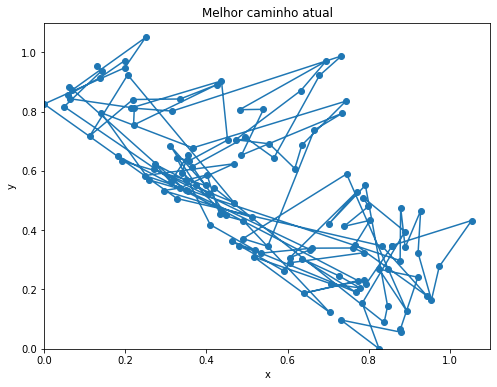

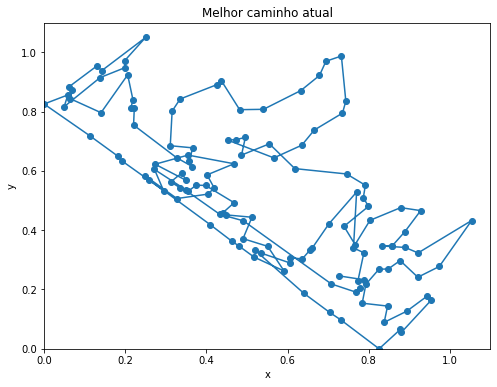

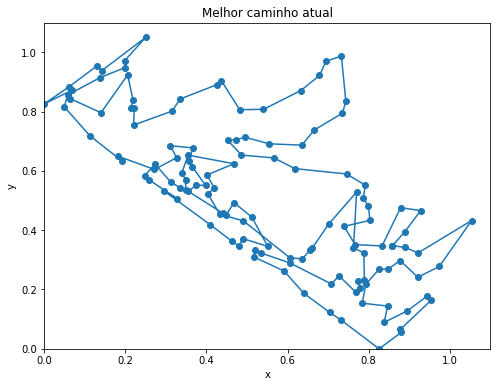

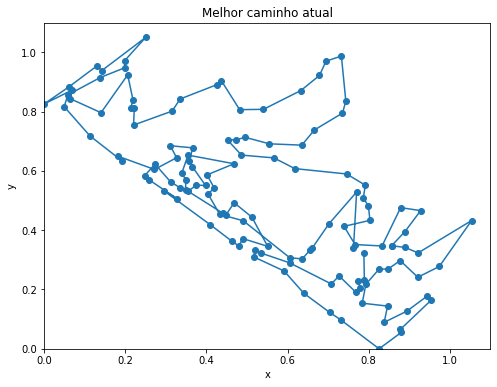

Menor distância:  8.676689278101549


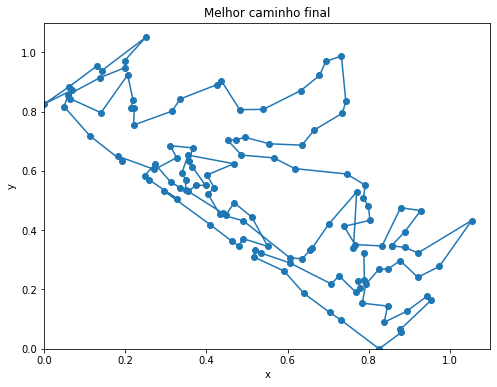

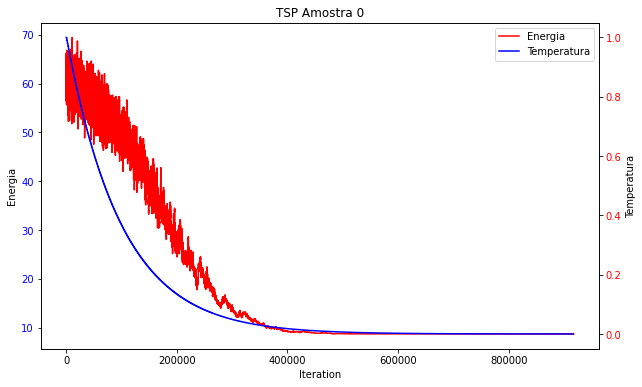

In [60]:
Ti = 1
dt = 0.99
Tf = 0.0001
mc_steps_num = 1000

en_list = tsp_annealing(Ti,Tf,dt,mc_steps_num)

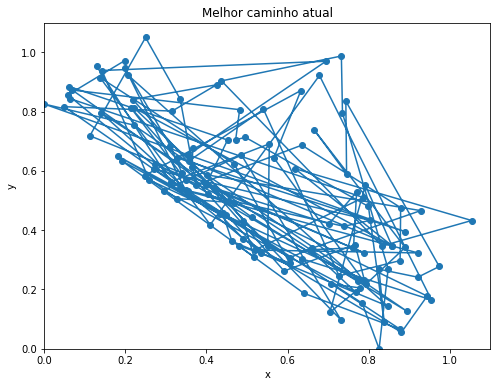

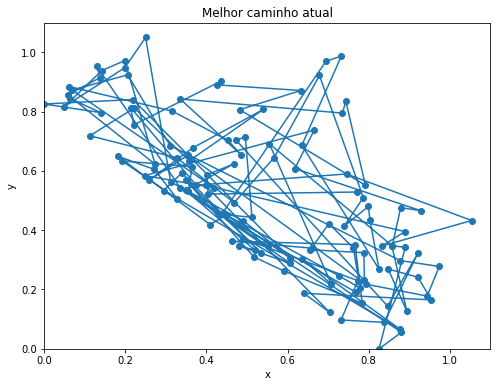

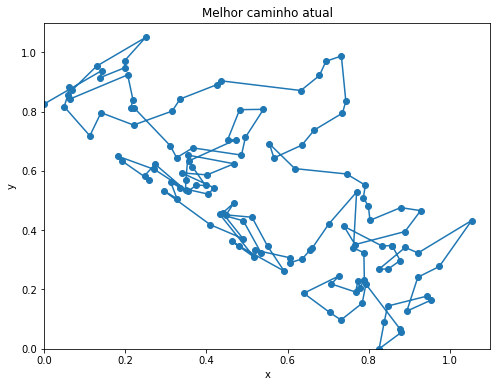

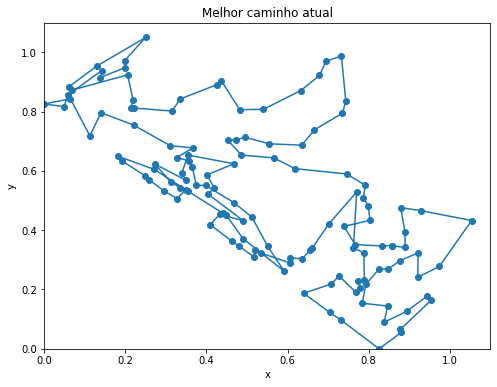

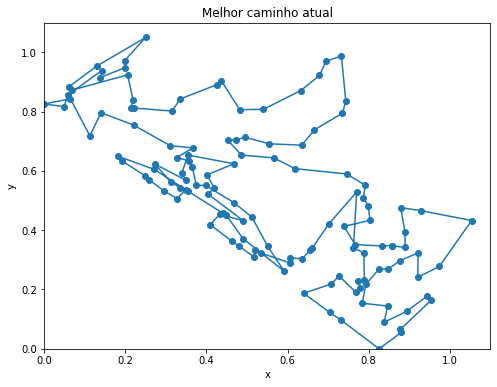

Menor distância:  8.742526595015079


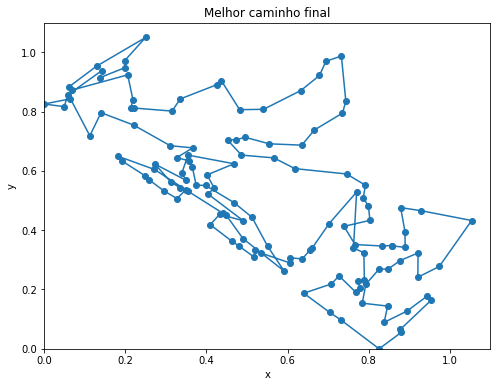

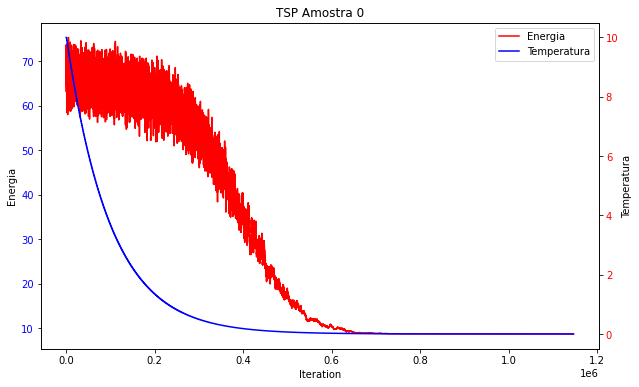

In [61]:
Ti = 10
dt = 0.99
Tf = 0.0001
mc_steps_num = 1000

en_list = tsp_annealing(Ti,Tf,dt,mc_steps_num)

Primeiro fizemos uma análise do efeito do aumento de temperatura inicial mantendo os outros parâmetros iguais. Nisso, constatamos que quanto maior o valor da temperatura, há mais mudanças de energia mesmo que para um estado pior. Logo, quanto maior for a temperatura inicial, percorremos mais nosso espaço de busca em busca do mínimo global. E também constatamos que com a diminuição da temperatura, vamos reduzindo nossos espaço de busca e convergindo para um mínimo que **pode** ser o global.

Menor distância:  9.608172031119466


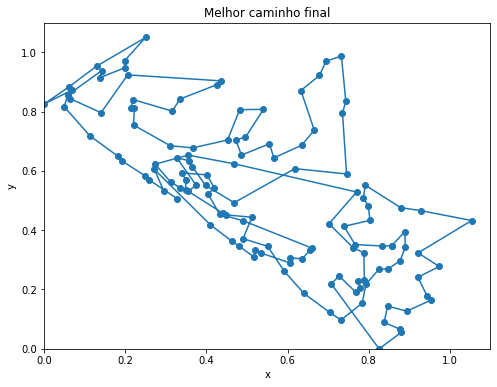

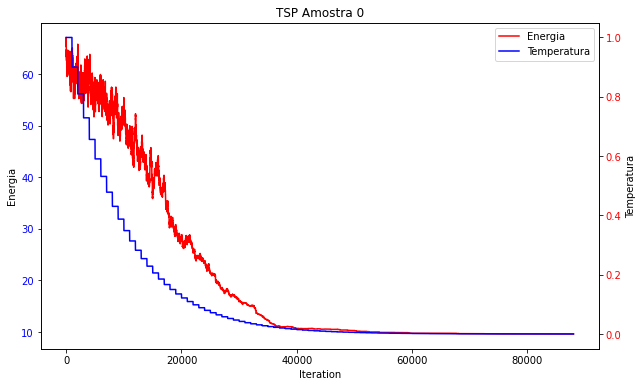

In [62]:
Ti = 1
dt = 0.90
Tf = 0.0001
mc_steps_num = 1000

tsp_annealing(Ti,Tf,dt,mc_steps_num)

Agora, comparando a primeira com esta última análise, na qual mudamos o protocolo de redução da temperatura. Podemos ver que com um protocolo de decaimento mais rápido, exploramos menos nosso espaço de busca e acabamos ficando presos em mínimos locais. Visto que, a menor distância encontrada aqui (9.6081) foi signitivamente maior que a primeira (8.6766).

Outro ponto a ressaltar é que como a **Ti=1** e o decaimento rápido são feitas bem menos passos de Monte Carlo, consequentemente, exploramos bem menos possibilidades de caminho e acabamos ficando um pouco mais longe da distância mínima. Tanto que acabamos plotando apenas o caminho final. Não chegamos a efetuar 200000 passos de Monte Carlo.

Achamos o Simulated Annealing interessante para o TSP, a possibilidade de ir "calibrando" a busca pelo menor caminho usando a temperatura e o protocolo de decaimento é o que chamou nossa atenção. Mas, ao mesmo tempo, experienciamos que não é simples determinar estes parâmetros de forma a aumentar as chances de achar a distância mínima.